<a href="https://colab.research.google.com/github/AndrewBoessen/CSCI3387_Notebooks/blob/main/SkiingDataCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=8236be3e79f8633d9bb170f81e606295aab8a5045ac4ed115a53edffc2cbb996
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import numpy as np


def process_images(images, noise_mean=0, noise_std=1):
    # Assuming 'images' is your 1000 x 210 x 160 x 3 array
    # Create a copy of the original images to avoid modifying the input
    processed_images = images.copy().astype(np.float32)

    # Define white color
    white = np.array([236, 236, 236], dtype=np.float32)

    # Function to find the border extent
    def find_border(arr, axis):
        is_black = np.all(arr == 0, axis=axis)
        borders = np.where(~is_black)[0]
        return borders[0] + 1 if len(borders) > 0 else 0

    # Process each image
    for i in range(images.shape[0]):
        img = processed_images[i]

        # Find borders
        top_border = find_border(img, axis=(1, 2))
        bottom_border = img.shape[0] - find_border(img[::-1], axis=(1, 2))
        left_border = find_border(img, axis=(0, 2))
        right_border = img.shape[1] - find_border(img[:, ::-1], axis=(0, 2))

        # Replace black borders with white
        img[:top_border] = white
        img[bottom_border:] = white
        img[:, :left_border] = white
        img[:, right_border:] = white

        # Add Gaussian noise
        noise = np.random.normal(noise_mean, noise_std, img.shape)
        img += noise

        # Clip values to ensure they're in the valid range [0, 255]
        np.clip(img, 0, 255, out=img)

    return processed_images.astype(np.uint8)

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation
import numpy as np

# Function to collect trajectories
def collect_trajectories(env, num_trajectories, max_steps):
    trajectories = []

    for _ in range(num_trajectories):
        observation, _ = env.reset()
        trajectory = [observation]

        for _ in range(max_steps):
            action = env.action_space.sample()  # Random action
            observation, _, terminated, truncated, _ = env.step(action)
            trajectory.append(observation)

            if terminated or truncated:
                break

        trajectories.append(np.array(trajectory))

    return trajectories

# Create and wrap the environment
env = gym.make("ALE/Skiing-v5", obs_type="rgb")
custom_shape = (256, 256)
env = ResizeObservation(env, shape=custom_shape)

# Set parameters
num_trajectories = 10
max_steps = 100

# Collect trajectories
trajectories = collect_trajectories(env, num_trajectories, max_steps)

# Convert trajectories to a single numpy array
all_observations = np.concatenate(trajectories, axis=0)

all_observations = process_images(all_observations)

# Print information about the collected data
print(f"Number of trajectories: {len(trajectories)}")
print(f"Shape of all observations: {all_observations.shape}")
print(f"Min value: {all_observations.min()}, Max value: {all_observations.max()}")

# Optional: Save the data to a file
np.save("skiing_observations.npy", all_observations)

env.close()

Number of trajectories: 10
Shape of all observations: (1010, 256, 256, 3)
Min value: 0, Max value: 241


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


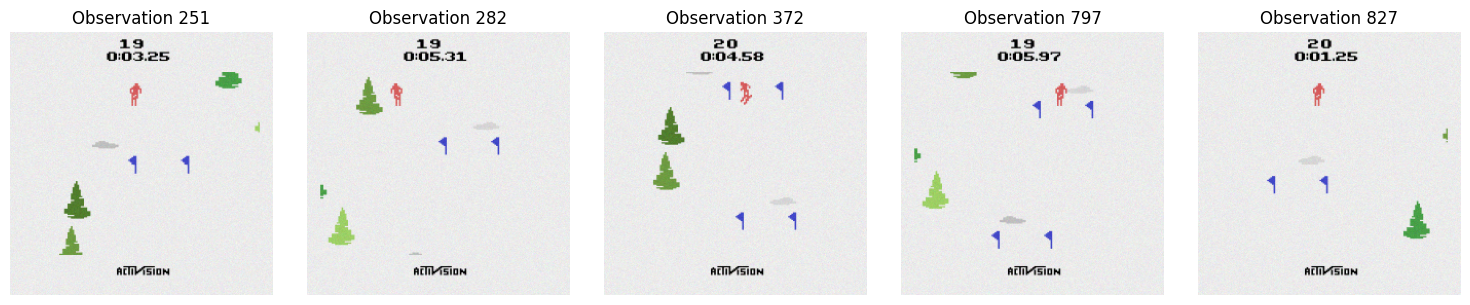

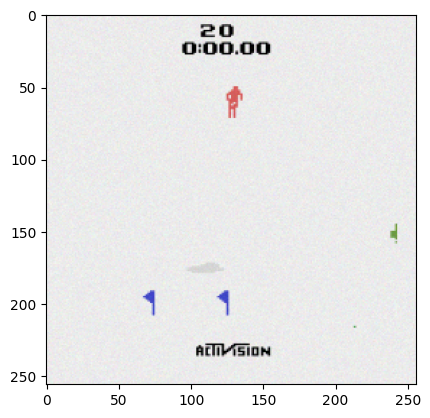

In [ ]:
import matplotlib.pyplot as plt

# Function to plot multiple observations
def plot_observations(observations, num_plots=5, figsize=(15, 3)):
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)
    for i in range(num_plots):
        idx = np.random.randint(0, len(observations))
        axes[i].imshow(observations[idx])
        axes[i].axis('off')
        axes[i].set_title(f"Observation {idx}")
    plt.tight_layout()
    plt.show()

# Plot random examples
plot_observations(all_observations)
plt.imshow(all_observations[0])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')